In [1]:
# 使用精确模式，进行文本分析
# 过程：
# 从mongo数据库提取数据
# 对提取的数据进行处理：分词，去掉标点符号，去掉stop words，提取词干
# 建立 paper_vector 同样保存在mongo数据库中
# 今晚需要建立 question_no => 分词，每一个词具有一个weight的结构
# 如果要计算两个question的cosine_similairty做为其相似度

# reference: https://github.com/goto456/stopwords 
import jieba
import jieba.analyse
from pymongo import MongoClient
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans,DBSCAN
from yellowbrick.cluster import KElbowVisualizer
import re

stopwords_file = "E:\workspace_python\zhihu_hot\zhihu_hot_list_clustering\stop_words.txt"

# read file in line and return a list
def read_file(file_name):
    fp = open(file_name, "r", encoding="utf-8")
    content_lines = fp.readlines()
    fp.close()
    #去除行末的换行符，否则会在停用词匹配的过程中产生干扰
    for i in range(len(content_lines)):
        content_lines[i] = content_lines[i].rstrip("\n")
    return content_lines

stopwords = read_file(stopwords_file)

# tokenize a str and return a list of words 
def tokenize(txt):
    r = '[’!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]+'
    txt = re.sub(r,"",txt)
    txt = txt.replace("	","")
    txt = txt.replace("\n","")
    txt = txt.replace("\u200b","")
    return jieba.lcut(txt,cut_all=False)

# get question contents
def get_question_contents():
    # init mongo client
    client = MongoClient("localhost",61003)
    db = client['zhihu_data']
    hot_answer = db.zhihu_hot_answer

    # read all data in mongo
    answers = hot_answer.find()
    question_contents = []
    question_no = []
    question_title = []
    for answer in answers:
        text = []
        text.append(answer['question_title'])
        for question_answer in answer['answers']:
            text.append(question_answer)
        question_content = " ".join(text)
        question_contents.append(question_content)
        question_no.append(answer["question_no"])
        question_title.append(answer['question_title'])
    return question_contents,question_no,question_title

In [3]:
# 获取tfidf document-term maxtrix
# max_df:0.2 如果一个term出现在超过20%的question中，则这个term没有意义
# min_df:4 如果一个term出现在小于4篇question中，则这个term没有意义
# max_features=200000：只考虑tf前200000的features
tfidf_vectorizer = TfidfVectorizer(max_df=0.2,min_df=3, tokenizer=tokenize, lowercase=False,stop_words=stopwords)
question_contents,question_nos,question_titles = get_question_contents()
tfidf_matrix_raw = tfidf_vectorizer.fit_transform(question_contents)
print(tfidf_matrix_raw.shape)

(867, 18644)


In [5]:
# dimession reduction 降维
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# n = 500
svd = TruncatedSVD(500)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

tfidf_matrix = lsa.fit_transform(tfidf_matrix_raw)

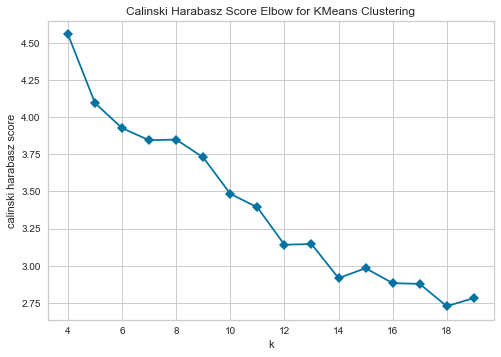

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [4]:
# kmeans clustering
model = KMeans(init='k-means++', max_iter=200)
visulizer = KElbowVisualizer(
    model, k=(4,20), metric='calinski_harabasz', timings=False
)
visulizer.fit(tfidf_matrix)
visulizer.show()

In [9]:
# km 
true_k = 14
km = KMeans(n_clusters=true_k,init='k-means++', max_iter=200)
kr = km.fit(tfidf_matrix)
clusters = kr.labels_

In [10]:
# print k-means result in a file
count = {}
result = {}
for i in range(len(clusters)):
    if count.get(clusters[i]) == None:
        count[clusters[i]] = 1
    else:
        count[clusters[i]] = count[clusters[i]]+1
    if result.get(clusters[i]) == None:
        result[clusters[i]] = [(question_nos[i],question_titles[i])]
    else:
        result[clusters[i]].append((question_nos[i],question_titles[i]))
        
for cluster_index, questions in result.items():
    kr = open("E:\workspace_python\zhihu_hot\zhihu_hot_list_clustering\k-means_results\k_means_plus_result"+str(cluster_index)+".txt","w",encoding="utf-8")
    kr.write("cluster:"+str(cluster_index)+"; count:"+str(count[cluster_index])+"\n")
    for question in questions:
        kr.write("{0}, {1}\n".format(question[0],question[1]))
    kr.close()

In [11]:
# 显示数据
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster {0}; number of questions:{1}; Feature Words:".format(i, count[i]), end='')
    for ind in order_centroids[i, :true_k]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0; number of questions:83; Feature Words: 00 05 007 101 02 100 1800 13 11 125 1111 136 16GB 126
Cluster 1; number of questions:46; Feature Words: 00 08 100 1013 04 05 07 1011 115 1600 117 107 126 1617
Cluster 2; number of questions:100; Feature Words: 00 01 04 108 07 1012 105 1111 112 18 11 102 110 19
Cluster 3; number of questions:58; Feature Words: 00 08 1099 05 007 10000 1012 12 1200 112 09 02 1112 04
Cluster 4; number of questions:120; Feature Words: 00 007 10w 1015 1013 1080 1020 1012 114 136 1718 09 08 05
Cluster 5; number of questions:60; Feature Words: 04 00 09 100g 06 105 1000 121 103 100 1015 02 08 129
Cluster 6; number of questions:91; Feature Words: 00 002 07 05 10000 007 102 100g 06 16 15 126 1600 112
Cluster 7; number of questions:37; Feature Words: 00 01 1030 1020 109 110 175 117 111 148 114 02 03 1520
Cluster 8; number of questions:22; Feature Words: 10000 04 00 06 101 108 105 1020 02 1013 007 13 1500 150
Cluster 9; number of questions:35; Feature Words: 02 00 0

In [9]:
# DBSCND 的聚类算法
# 1.225 - 4 - 3 最佳参数
dbc = DBSCAN(eps=1.1,min_samples=5)
db = dbc.fit(tfidf_matrix)
labels = db.labels_
print(len(labels))

867


In [10]:
# 展示DBSCAN的结果
result_db = {}
for i in range(len(labels)):
    if labels[i] != -1:
        if result_db.get(labels[i]) == None:
            result_db[labels[i]] = [question_titles[i]]
        else:
            result_db[labels[i]].append(question_titles[i])

dr = open("E:\workspace_python\zhihu_hot\zhihu_hot_list_clustering\dbscan_results\dbscan_result.txt", "w", encoding="utf-8")
for cluster_index,titles in result_db.items():
    dr.write("cluster "+str(cluster_index)+"; number of questions:"+str(len(titles))+"\n")
for cluster_index,titles in result_db.items():
    dr.write("cluster:"+str(cluster_index)+"\n")
    for title in titles:
        dr.write(title+"\n")
dr.close()